### Libraries as necessary

In [142]:
import pandas as pd
import numpy as np 

import glob # reading multiple files in the same directory
import ast # because multiple medications on the same day are kept as list, they are read as String if you were to export and import again, use ast.literal_eval to read them as list again

from tqdm import tqdm # progress bar
tqdm.pandas()

import shutup # it just makes me feel better
shutup.please()

In [ ]:
def find_files(paths, years=False, extension="", lookback=0):
    '''
    Find files that match the specified criteria.

    Parameters
    ----------
    paths : str or list of str
        Folder(s) to look for the data files. It MUST be a raw string (r"").
    years : str or list of str, oprional
        Year of the datafile to look for.
        If multiple years are provided in a list, it is considered a range.
        If not provided, it looks for all files. then lookback is ignored.
    extension : str or list of str, optional
        File types to look for.
        The default is any extension.
    lookback : int, optional
        The number of years to look back. For orders, this should be 1 since the medication can be ordered first and then billed later.
        If multiple years are provided in a list, it looks back from the minimum year.
        The default is 0.

    Returns
    -------
    files : list
        List of files that match the criteria.
    '''

    if isinstance(paths, str):
        paths = [paths]
    
    if isinstance(extension, str):
        extension = [extension]
    paths = [path + "/*" + ext for path in paths for ext in extension]

    files = [glob.glob(path) for path in paths]
    files = [file for filelist in files for file in filelist]

    if years:
        if isinstance(years, list):
            years = list(map(int, years))
        else:
            years = [int(years)]
        
        year_list = list(range(min(years) - lookback, max(years) + 1))

        files = [file for file in files if any(str(year) in file for year in year_list)]
        
    return files

### ICD-10 criteria

ICD-10 codes used to identify are I10, I11, I12, I13 and I15. 

``str(x).startswith(tuple(icd10))`` is used because ICD-10 code is Alpha character followed by multiple numerical characters (A12344). So, ``startswith`` catches all I10, I100, I101, I1010 and so on.

This is the required input format. <br /> 

| Primary Key | Date | ICD code |
|-|-|-|
| A | 2023-01-01 | (not relevant) |
| A | 2023-01-10 | (relevant) |
| A | 2023-01-15 | (relevant) |
| A | 2023-02-01 | (relevant) |

The first date of diagnosis for each of these codes is considered as date of HT diagnosis, so only the earliest date is kept. <br /> 

| Primary Key | Date | ICD code |
|-|-|-|
| A | 2023-01-10 | (relevant) |

In [143]:
# Diagnosis

icd10 = ["I10", "I11", "I12", "I13", "I15"]

paths = "folders including diagnosis data"

files = find_files(paths, years="2023")
read = []
for file in tqdm(files):
    temp = pd.read_csv(file)
    read.append(temp)

dx = pd.concat(read)

flag = dx["D035KEY"].apply(lambda x: str(x).startswith(tuple(icd10)))
dx = dx[flag]
dx = dx[["ENC_HN", "D001KEY", "D035KEY"]]
dx["D001KEY"] = pd.to_datetime(dx["D001KEY"], format="%Y%m%d")
dx = dx[dx["D001KEY"]>= pd.to_datetime("20230101", format="%Y%m%d")]
dx = dx.sort_values(["ENC_HN", "D001KEY"])
dx = dx.loc[dx.groupby("ENC_HN").D001KEY.idxmin()] # keeping earliest date
dx = dx.drop_duplicates("ENC_HN", keep="first")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:05<00:00,  2.84s/it]


### Medication criteria

The same goes for medication. We identified the medications prescribed in Ramathibodi Hospital and filtered for relevant drug classes. The mapping table was prepared by Dr Kunlawat Thadanipon and Dr Thosaphol Limpijankit.

In [144]:
"Medication"

key = pd.read_excel(r"path\map_list\cohort_anti_HT.xlsx", sheet_name="selected drug classes")
key.head()

,ramadrugcode,drugname,combination,combinationsplit,atc,atcdeesc,id,drugclass
0,AMLP1T-,Amlodipine 5 mg,Amlodipine besylate,Amlodipine besylate,C08CA,Dihydropyridine derivatives,1,CCB_DHP
1,AMLP2T-,Amlodipine 10 mg,Amlodipine besylate,Amlodipine besylate,C08CA,Dihydropyridine derivatives,2,CCB_DHP
2,NORV1T-,Norvasc 5 mg,Amlodipine besylate,Amlodipine besylate,C08CA,Dihydropyridine derivatives,3,CCB_DHP
3,NORV2T-,Norvasc 10 mg,Amlodipine besylate,Amlodipine besylate,C08CA,Dihydropyridine derivatives,4,CCB_DHP
4,TENM1T-,Tenormin 50 mg,Atenolol,Atenolol,C07AB,"Beta blocking agents, selective",5,beta_blocker


This is the required input format. <br /> 

| Primary Key | Date | Drugcode |
|-|-|-|
| A | 2023-01-01 | (not relevant) |
| A | 2023-01-10 | (relevant) |
| A | 2023-01-10 | (relevant) |
| A | 2023-02-01 | (relevant) |

Essentially the goal is to identify the transactions where relevant Anti Hypertensive medication was given, and keep the earliest date. Please note that multiple relevant medications can be prescribed on the same day. <br /> 

| Primary Key | Date | Drugcode |
|-|-|-|
| A | 2023-01-10 | (relevant) |
| A | 2023-01-10 | (relevant) |


In [145]:
paths = "folders including medication data"

files = find_files(paths, years="2023")

read = []
for file in tqdm(files):
    try:
        temp = pd.read_csv(file)
    except:
        temp = pd.read_parquet(file)
    temp = temp[["ENC_HN", "D001KEY", "D033KEY"]]
    temp.columns = ["ENC_HN", "D001KEY", "CODE"]
    # selected medications
    temp = temp[temp["CODE"].isin(key["ramadrugcode"])]
    temp = temp[temp["D001KEY"] == temp.groupby("ENC_HN")["D001KEY"].transform("min")] # keeping earliest date
    temp = temp.reset_index(drop=True)
    read.append(temp)

med = pd.concat(read)
med["D001KEY"] = pd.to_datetime(med["D001KEY"], format="%Y%m%d")
med = med[med["D001KEY"]>= pd.to_datetime("20230701", format="%Y%m%d")]
med = med[med["D001KEY"]<= pd.to_datetime("202312311", format="%Y%m%d")]

med = med.sort_values(["ENC_HN", "D001KEY"])
med = med.loc[med.groupby("ENC_HN").D001KEY.idxmin()]

med = med.groupby(["ENC_HN", "D001KEY"])["CODE"].apply(lambda x: list(set(x))).reset_index() # you need this


100%|██████████| 1/1 [00:21<00:00, 21.05s/it]


### New cases of Hypertension

This step is not necessary for the first time. For me, I am updating my cohort so subjects already in the cohort are removed.

In [146]:
# because it is an update, I remove old cases.

old_hn = pd.read_csv(r"G:\Shared drives\teza_dump\HT_Hteza\2010-202306\hthn_2010_202306.csv")

new_dx = dx[~dx.ENC_HN.isin(old_hn.ENC_HN)].reset_index(drop=True)
new_dx.ENC_HN.nunique()

new_med = med[~med.ENC_HN.isin(old_hn.ENC_HN)].reset_index(drop=True)
new_med.ENC_HN.nunique() 

# these numbers are up to changes since new_dx can be med_only if prescription is observed earlier than diagnosis

### Merging for tentative number of cases

This is diagnosis data. <br /> 
| Primary Key | Date | ICD |
|-|-|-|
| A | 2023-01-09 | (icd code) |
| C | 2023-02-13 | (icd code) |

This is medication data. <br /> 
| Primary Key | Date | MED |
|-|-|-|
| A | 2023-01-10 | (med code) |
| B | 2023-01-13 | (med code) |
| C | 2023-02-13 | (med code) |

This is merging for tentative number of cases. While the patient might be in both ICD and Medication groups, we identify by the first date of diagnosis. <br /> 

| Primary Key | ICD_Date | Med_Date | First_Date | flag |
|-|-|-|-|-|
| A | 2023-01-09 | 2023-01-10 | 2023-01-09 | icd |
| B | | 2023-01-13 | 2023-01-13 | med |
| C | 2023-02-13 | 2023-02-13 | 2023-02-13 | both |

In these subjects, subject A is considered ICD only, subject B as Anti-H only and C as both ICD-10 and Anti-H group.



In [147]:
new_dx.columns = ["ENC_HN", "ICD_DATE", "ICD"]
new_med.columns = ["ENC_HN", "MED_DATE", "MED"]

data = new_dx.merge(new_med, on = ["ENC_HN"], how="outer")
data["D001KEY"] = data[["ICD_DATE", "MED_DATE"]].min(1) # first date of HT is whichever date that happen first.
data["flag"] = np.where(data["D001KEY"]!=data["ICD_DATE"], "med", # if ICD does not happen first, it is medication group.
                        np.where(data["D001KEY"]!=data["MED_DATE"], "icd", # if medication does not happen first, it is ICD group.
                                 "both")) # otherwise, it is both

print("No of possible HT subjects are {:,}.".format(data.ENC_HN.nunique())) # 10645

check = ["med", "icd"]
for flag in check:
    print("For {} group, the number of subjects is {:,}.".format("all "+[i for i in check if i!=flag][0], len(data[data.flag!=flag])))
    
for flag in ["icd", "both", "med"]:
    print("For {} group, the number of subjects is {:,}.".format("only "+flag, len(data[data.flag==flag])))
    
data.to_pickle(r"path/new_case/merged_hn_inferred.csv.pkl")

No of possible HT subjects are 10,645.
For icd group, the number of subjects is 3,429.
For both group, the number of subjects is 1,060.
For med group, the number of subjects is 6,156.


### Filtering the medication only cases

Since medications are identified using ramadrugcodes, they are transformed into generic drug classes using the previously shown mapping table.

``ast.literal_eval`` is required if the data file is imported again since Pandas does not import ``dtype`` as ``list``.

In [152]:
key = pd.read_excel(r"path\map_list\cohort_anti_HT.xlsx", sheet_name="selected drug classes")
key = key.set_index("ramadrugcode")["subclass"].to_dict()

med_only = data[data["flag"]=="med"].reset_index(drop=True) # med only group

try:
    med_only["drugclass"] = med_only["MED"].progress_apply(lambda x: [key[i] for i in x])
except:
    med_only["drugclass"] = med_only["MED"].progress_apply(lambda x: [key[i] for i in ast.literal_eval(x)])

med_only["drugclass"] = med_only["drugclass"].progress_apply(lambda x: list(set(x)))
print("\nMapping ramadrugcodes such as {} to generic drugclass such as {}".format(med_only["MED"][0], med_only["drugclass"][0]))
med_only[["MED", "drugclass"]].head()

100%|██████████| 6156/6156 [00:00<00:00, 684049.58it/s]


Mapping ramadrugcodes such as ['BISS1T-', 'AMLP2T-'] to generic drugclass such as ['CCB_DHP', 'beta_blocker']


,MED,drugclass
0,"[BISS1T-, AMLP2T-]","[CCB_DHP, beta_blocker]"
1,[LOSL-T-],[ARB]
2,[ENAR-T-],[ACEI]
3,"[LOSL-T-, AMLP1T-]","[CCB_DHP, ARB]"
4,"[CRDP2I-, CRDP1I-, AVEX1I-]","[CCB_DHP, alpha_beta_blocker]"


Other indications for specific drug classes were prepared by Dr Kunlawat Thadanipon and Dr Thosaphol Limpijankit. The function ``check_history`` look for other indications in patient's history using ICD-10 codes.

The input is list of medications and the date of prescription to check. <br /> 

| Primary Key | Date | drugclass |
|-|-|-|
| A | 2023-01-10 | [drug A, drug B] |

If they have corresponding history, the output is tuple of indication and medication. <br /> 

| Primary Key | Date | drugclass | Check History|
|-|-|-|-|
| A | 2023-01-10 | [drug A, drug B] | [drug A, (other indication on 2022-10-04, drug B)] |

If the patient have at least one Anti-H that does not correspond with other indication, we include them.

In [159]:
# Other indication
indi = pd.read_excel(r"path\map_list\medication_map_2301.xlsx", sheet_name="other indications")
indi["ICD-10"] = indi["ICD-10"].apply(lambda x: [("".join(i.strip().split("."))).ljust(4, "0") for i in x.split(",")])

paths = "folders including diagnosis data"

files = find_files(paths)

read = []
for file in files:
    temp = pd.read_csv(file)
    temp = temp[temp.ENC_HN.isin(med_only.ENC_HN)]
    temp = temp[temp.D035KEY.isin(indi["ICD-10"].sum())]
    temp["D001KEY"] = pd.to_datetime(temp["D001KEY"], format="%Y%m%d")
    temp = temp[["ENC_HN", "D001KEY", "D035KEY"]]
    read.append(temp)

dx = pd.concat(read)

def check_history(drugclass, hn, dx = dx, indimap = indi):
    res = drugclass
    if (hn in list(dx.ENC_HN)) & (drugclass in list(indimap["subclass"])):
        oth_indi = indimap[indimap["subclass"]==drugclass]
        cause = oth_indi["Other Indications"].values[0]
        oth_indi = oth_indi["ICD-10"].values[0]
        dx = dx[dx.D035KEY.isin(oth_indi)]
        if len(dx)>0:
            dx = dx[dx.D001KEY==dx.D001KEY.min()]["D001KEY"].astype(str).values[0]
            res = ("{} on {}".format(cause, dx), drugclass)
        else:
            pass
    else:
        pass
    return res

med_only["check_history"] = med_only.progress_apply(lambda row: [check_history(i, row["ENC_HN"]) for i in row["subclass"]], axis=1)

print("For example, this is the list of medications to check {} and \nthis is the corresponding history {}.".format(med_only.loc[2442,"drugclass"], med_only.loc[2442,"check_history"]))

100%|██████████| 6156/6156 [00:00<00:00, 13210.32it/s]

For example, this is the list of medications to check ['CCB_nonDHP', 'beta_blocker'] and 
this is the corresponding history [('Arrhythmias on 2010-01-11', 'CCB_nonDHP'), ('Hyperthyroidism on 2010-04-12', 'beta_blocker')].


In [172]:
# Boolean column to drop rows
# Some patients are given more than one medication and not all of them have other indications, we include them.
# So, I use minimum of the list.
med_only["check2"] = med_only["check_history"].apply(lambda x: min([1 if isinstance(i, tuple) else 0 for i in x]))

print("\nFor example patient with {}, we will include so boolean for drop is {}.".format(med_only.loc[3236,"check_history"], med_only.loc[3236,"check2"]))
print("For example patient with {}, we will exclude so boolean for drop is {}.".format(med_only.loc[2442,"check_history"], med_only.loc[2442,"check2"]))
print("Medication only patients with history of other indications is {}.".format(sum(med_only["check2"]>0)))

med_only[["drugclass", "check_history", "check2"]].sample(5, random_state=2023)


For example patient with ['CCB_DHP', 'alpha2_agonist', 'ARB', ('Hyperthyroidism on 2010-04-12', 'beta_blocker')], we will include so boolean for drop is 0.
For example patient with [('Arrhythmias on 2010-01-11', 'CCB_nonDHP'), ('Hyperthyroidism on 2010-04-12', 'beta_blocker')], we will exclude so boolean for drop is 1.
Medication only patients with history of other indications is 47.


,drugclass,check_history,check2
956,"[CCB_DHP, ARB]","[CCB_DHP, ARB]",0
4222,[beta_blocker],[beta_blocker],0
4985,[alpha_beta_blocker],[alpha_beta_blocker],0
2442,"[CCB_nonDHP, beta_blocker]","[(Arrhythmias on 2010-01-11, CCB_nonDHP), (Hyp...",1
4592,[CCB_DHP],[CCB_DHP],0


### Final Merge

Diagnosis of HT is inferred from medication, after we have dropped those subjects.

In [179]:
to_drop = med_only[med_only["check2"]>0] # 47
final_data = data[~data.ENC_HN.isin(to_drop.ENC_HN)]

print("No of possible HT subjects are {:,}.".format(data.ENC_HN.nunique())) # 10645

for flag in ["icd", "both", "med"]:
    print("For {} group, the number of subjects is {:,}.".format(flag, len(final_data[final_data.flag==flag])))

pd.concat([pd.DataFrame({"ENC_HN": ["A", "B", "C", "D", "E"]}), final_data[["D001KEY", "ICD_DATE", "ICD", "MED_DATE", "MED", "flag"]].head(5)], 1)

No of possible HT subjects are 10,645.
For icd group, the number of subjects is 3,429.
For both group, the number of subjects is 1,060.
For med group, the number of subjects is 6,109.


,ENC_HN,D001KEY,ICD_DATE,ICD,MED_DATE,MED,flag
0,A,2023-07-11,2023-07-11,I10,2023-07-11,[AMLP1T-],both
1,B,2023-02-23,2023-02-23,I10,NaT,NaN,icd
2,C,2023-01-09,2023-01-09,I10,2023-01-09,[LOSL-T-],both
3,D,2023-07-04,2023-07-07,I10,2023-07-04,"[BISS1T-, AMLP2T-]",med
4,E,2023-01-17,2023-01-17,I10,NaT,NaN,icd


### Summarization for Data Flow

In [ ]:
cohort_properties = {"icd10": len(data[data.flag=="icd"])+len(data[data.flag=="both"]),
                     "med": len(data[data.flag=="med"])+len(data[data.flag=="both"]),
                     "icd10_only":len(data[data.flag=="icd"]),
                     "both":len(data[data.flag=="both"]),
                     "anti_h_only":len(data[data.flag=="med"]),
                     "other_indication":sum(med_only["check2"]>0),
                     "dx":new_dx.ENC_HN.nunique(),
                     "infer_dx":len(final_data[final_data.flag=="med"]),
                     "ht":len(final_data),
                     "final_icd10_only":len(final_data[final_data.flag=="icd"]),
                     "final_both":len(final_data[final_data.flag=="both"]),
                     "final_anti_h_only":len(final_data[final_data.flag=="med"])}

In [ ]:
print("For the flow chart")
print("===========================")
print("ICD 10 for Hypertension (HT): n = {:,} | Anti-Hypertensive medication (Anti-H): n = {:,}".format(cohort_properties["icd10"], cohort_properties["med"]))
print("======tentative groups=====")
print("ICD-10 only: n = {:,}".format(cohort_properties["icd10_only"]), end=" | ")
print("both ICD-10 and Anti-H: n = {:,}".format(cohort_properties["both"]), end=" | ")
print("Anti-H only: n = {:,}".format(cohort_properties["anti_h_only"]))
print("======med only=============")
print("other indications: n = {:,}".format(cohort_properties["other_indication"]))
print("======final merge==========")
print("Diagnosis of HT: n = {:,} | Inferred Diagnosis of HT: n = {:,} ".format(cohort_properties["dx"], cohort_properties["infer_dx"]))
print("HT subjects: n = {:,}".format(cohort_properties["ht"]))
print("======sub-groups===========")
print("ICD-10 only: n = {:,}".format(cohort_properties["final_icd10_only"]), end=" | ")
print("both ICD-10 and Anti-H: n = {:,}".format(cohort_properties["final_both"]), end=" | ")
print("Anti-H only: n = {:,}".format(cohort_properties["final_anti_h_only"]))

For the flow chart
ICD 10 for Hypertension (HT): n = 4,483 | Anti-Hypertensive medication (Anti-H): n = 7,274
======tentative groups=====
ICD-10 only: n = 3,414 | both ICD-10 and Anti-H: n = 1,069 | Anti-H only: n = 6,205
======med only=============
other indications: n = 47
======final merge==========
Diagnosis of HT: n = 4,483 | Inferred Diagnosis of HT: n = 6,158 
HT subjects: n = 10,641
======sub-groups===========
ICD-10 only: n = 3,429 | both ICD-10 and Anti-H: n = 1,060 | Anti-H only: n = 6,109


In [ ]:
def ht_flow(cohort_properties=cohort_properties, study_period="01/2010 - 06/2023", dpi=0):
    # properties
    dot= Digraph(graph_attr={'rankdir': 'TB', 'splines': 'ortho', 'size': '20, 32', 'dpi': str(dpi)},
                node_attr={'shape': 'box', 
                            'width': '1.8', 'height': '0.8', 'fixedsize': 'true',
                            'fontname':'Helvetica', 'fontsize':'10', 'fontcolor':'black'})  # Top to bottom directed graph

    split_node = {'shape': 'point', 'label': None, 
                'width': '0.0001', 'height': '0.0001'}

    # nodes

    dot.node('A', 'Ramathibodi Hospital\nDatabase', _attributes={'shape': 'cylinder'})
    dot.node('1', _attributes=split_node)
        
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('B', 'Diagnosis\n{}\n(ICD-10)'.format(study_period))
        s.node('C', 'Prescription\n{}\n(Rama Drugcode)'.format(study_period))

    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('D', 'ICD-10 for\nHypertension (HT)\n(n = {:,})'.format(cohort_properties["icd10"]))
        s.node('E', 'Anti-Hypertension\nmedication (Anti-H)\n(n = {:,})'.format(cohort_properties["med"]))

    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('2', _attributes=split_node)
        s.node('3', _attributes=split_node)

    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('F', 'ICD-10 only\n(n = {:,})'.format(cohort_properties["icd10_only"]))
        s.node('G', 'both ICD-10\nand Anti-H\n(n = {:,})'.format(cohort_properties["both"]))
        s.node('H', 'Anti-H only\n(n = {:,})'.format(cohort_properties["anti_h_only"]))
        
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('4', _attributes=split_node)
        s.node('J', 'Other condition\n(n = {:,})'.format(cohort_properties["other_indication"]))

    with dot.subgraph() as s:
        s.node('5', _attributes=split_node)

    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('K', 'Diagnosis of HT\n(n = {:,})'.format(cohort_properties["dx"]))
        s.node('L', 'Inferred\nDiagnosis of HT\n(n = {:,})'.format(cohort_properties["infer_dx"]))

    with dot.subgraph() as s:
        s.node('6', _attributes=split_node)
        
    with dot.subgraph() as s:
        s.node('N', 'HT subjects\n(n = {:,})'.format(cohort_properties["ht"]))


    # arrows

    dot.edges(["AB", "AC"])

    dot.edge('B', 'D')
    dot.edge('C', 'E')

    dot.edge('D', '2', arrowhead='none')
    dot.edge('2', 'F')
    dot.edge('2', 'G')

    dot.edge('E', '3', arrowhead='none')
    dot.edge('3', 'G')
    dot.edge('3', 'H')

    dot.edge('H', '4', arrowhead='none')
    dot.edge('4', 'J', arrowhead='none')
    dot.edge('4', 'L')

    dot.edge('F', '5', arrowhead='none')
    dot.edge('G', '5', arrowhead='none')
    dot.edge('5', 'K')

    dot.edge('K', '6', arrowhead='none')
    dot.edge('L', '6', arrowhead='none')
    dot.edge('6', 'N')
    
    return dot

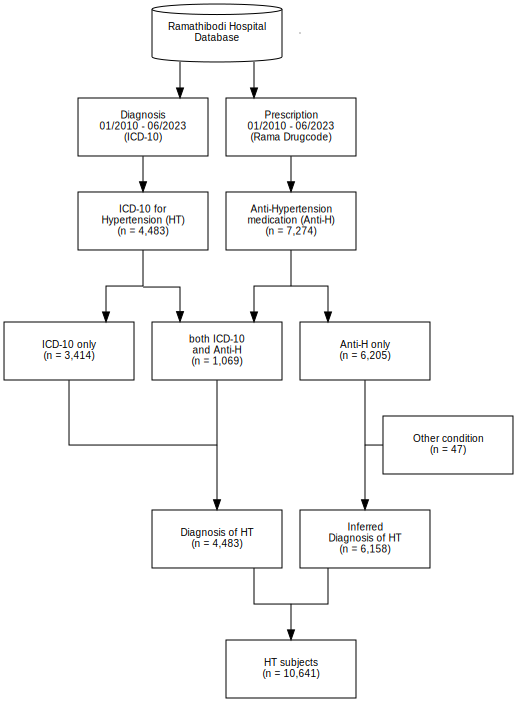

In [ ]:
dot = ht_flow()
dot

In [ ]:
dot = ht_flow(dpi=300)
dot.render(r'path/graphviz', format='png', cleanup=True, view=True)